## Audio Equalizer Code

### Filter Class Code
Describes filter-type object, which contains filter coefficients for low, mid, or high frequency filter, or no coefficients for unspecified filter.

In [1]:
from scipy.signal import kaiserord, firwin, freqz
from pylab import figure, plot, title, grid, xlabel, ylabel
import numpy as np

class Filter:
    def __init__(self, filter_type='none', num_coefs=99, nyquist_rate=22050, stop_band_attentuation_dB=60, low_transition_freq=400, high_transition_freq=4000):
        """
        __init__ Initializes filter parameters based on passed values

        Args:
            filter_type (str, optional): 'Low', 'mid', or 'high' to specify what type of filter to generate
                    Defaults to 'empty', indicating that no coefs should be generated
            num_coefs (int, optional): Number of filter coefficients to generate
                    Defaults to 99, keep this unless HLS code is changed as well
            nyquist_rate (int, optional): Nyquist rate of signal to filter
                    Defaults to 22050 for the sample audio file "elecric_guitar_sample.wav"
                    #TODO: Implement dynamic nyquist rate (out of scope for now)
            stop_band_attentuation_dB (int, optional): Attenuation frequency for filters
                    Defaults to 60dB
            low_transition_freq (int, optional): Frequency defining the intersection point of the low and mid frequency bands
                    Defaults to 400Hz
            high_transition_freq (int, optional): Frequency defining the intersection point of the mid and high frequency bands
                    Defaults to 4000Hz
        """
        self.filter_type = filter_type
        self.num_coefs = num_coefs
        self.nyquist_rate = nyquist_rate
        self.transition_width = 200 / nyquist_rate
        self.stop_band_attenuation_dB = stop_band_attentuation_dB
        self.low_transition_freq = low_transition_freq
        self.high_transition_freq = high_transition_freq
        
        self.filter_coefs = []
        
        self.calculate_filter_order()
        self.generate_filter_coefs()
    
    
    def calculate_filter_order(self):
        """
        calculate_filter_order Calculates filter order based on transition width and attenuation
        """
        # Calculates filter order and beta value based on transition width and attenuation
        self.FIR_order, self.beta = kaiserord(self.stop_band_attenuation_dB, self.transition_width)
        
        # Scaled by 3 to improve accuracy, this will be used as the number of coefficients to generate
        self.FIR_order *= 3
        
        # Some limitations around filters with an even number of coefficients, so make it odd to avoid this altogether
        if self.FIR_order % 2 == 0:
            self.FIR_order += 1
    
    
    def generate_filter_coefs(self):
        """
        generate_filter_coefs Calls filter generation function based on filter type
        """
        if self.filter_type == "low":
            self.generate_lowfreq_filter()
        elif self.filter_type == "mid":
            self.generate_midfreq_filter()
        elif self.filter_type == "high":
            self.generate_highfreq_filter()
        elif self.filter_type == 'none':
            pass
    
    
    def generate_lowfreq_filter(self):
        """
        generate_lowfreq_filter Generates filter coefficients for a lowpass filter with given parameters
        """
        self.filter_coefs = firwin(self.num_coefs, self.low_transition_freq, pass_zero='lowpass', fs=self.nyquist_rate*2)

    
    def generate_midfreq_filter(self):
        """
        generate_midfreq_filter Generates filter coefficients for a bandstop filter with given parameters
        """
        self.filter_coefs = firwin(self.num_coefs, [self.low_transition_freq / self.nyquist_rate, self.high_transition_freq / self.nyquist_rate], pass_zero='bandpass')

    
    def generate_highfreq_filter(self):
        """
        generate_highfreq_filter Generates filter coefficients for a highpass filter with given parameters
        """
        self.filter_coefs = firwin(self.num_coefs, self.high_transition_freq, pass_zero='highpass', fs=self.nyquist_rate*2)

    
    def plot_filter(self):
        """
        plot_filter Plots the frequency response of the filter
        """        
        figure()

        # Computes the frequecy response of the filter
        response_frequencies, complex_response = freqz(self.filter_coefs, worN=8000)
        
        plot((response_frequencies / np.pi) * self.nyquist_rate, np.absolute(complex_response), linewidth=2)
        
        title("Filter Curves")
        xlabel("Frequency (Hz)")
        ylabel("Filter Gain")
        
        grid(True)
        

print("Created Filter Class")

Created Filter Class


#### Filter Test Code
Generates low, mid, and high frequency filters, then combined and scaled coefficients into a single filter

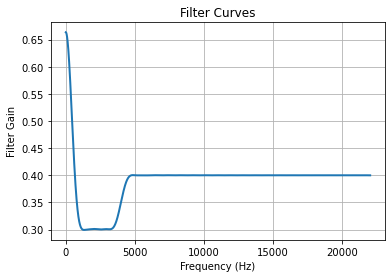

In [2]:
lowfreq_filter = Filter('low')
midfreq_filter = Filter('mid')
highfreq_filter = Filter('high')

# lowfreq_filter.plot_filter()
# midfreq_filter.plot_filter()
# highfreq_filter.plot_filter()

new_filter = Filter()
new_filter.filter_coefs = lowfreq_filter.filter_coefs * 0.6 + midfreq_filter.filter_coefs * 0.3 + highfreq_filter.filter_coefs * 0.4
new_filter.plot_filter()

### Audio Signal Class Code
Describes audio_signal-type objects, which contains various methods for reading/writing audio signal to/from wav files, and methods for equalizing the signal either in software or hardware.

In [35]:
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

from pynq import Overlay
from pynq import allocate

class Audio_Signal:
    def __init__(self, input_file_path, output_file_path):
        """
        __init__ Initializes input and output filepaths based on passed parameters

        Args:
            input_file_path (string): Input wav file
            output_file_path (string): Output wav file
        """
        self.input_file_path = input_file_path
        self.output_file_path = output_file_path
        
        self.sw_output_file_path = "./outputs/SW_equalized_output.wav"
        self.hw_output_file_path = "./outputs/HW_equalized_output.wav"

    
    def load_audio(self):
        """
        load_audio Reads audio data from input wav file and extracts signal parameters
        """
        audio_signal = wave.open(self.input_file_path, 'r')
        
        # Pull signal parameters from header
        self.frame_count = audio_signal.getnframes()
        self.channel_count = audio_signal.getnchannels()
        self.sample_width = audio_signal.getsampwidth()
        self.sample_rate = audio_signal.getframerate()
        self.frame_rate = audio_signal.getframerate() * 2

        # Load audio frames from wav file and convert to numpy array
        self.audio_frames = audio_signal.readframes(self.frame_count)
        self.audio_frames = np.frombuffer(self.audio_frames, dtype = np.int16)
        
        # Determine length of audio signal (Should be 2 * frame_cound)
        self.audio_length = len(self.audio_frames)
    
    
    def plot_audio_data(self):
        """
        plot_audio_data Plots amplitude vs. time of audio signal
        """
        # Generate time signal based on audio data and frame rate
        self.time_signal = np.linspace(0, self.audio_length / self.frame_rate, num = self.audio_length)

        plt.figure()
        plt.plot(self.time_signal, self.audio_frames)
        plt.xlabel("Time (s)")
        plt.ylabel("Signal Amplitude")

        plt.show()
        
    
    ###   SOFTWARE EQUALIZATION FUNCTIONS   ###
    def SW_equalize(self, lowfreq_gain, midfreq_gain, highfreq_gain):
        """
        SW_equalize Equalizes the audio signal, scaling by respective gain for low, mid, and high frequencies

        Args:
            lowfreq_gain (float): Specifies gain of low frequency components of audio signal
                    Must be positive for proper equalization
            midfreq_gain (float): Specifies gain of mid frequency components of audio signal
                    Must be positive for proper equalization
            highfreq_gain (float): Specifies gain of high frequency components of audio signal
                    Must be positive for proper equalization
        """
        self.num_coefs = 99

        # Generate, combine, and scale filter coefficients for software function
        self.make_sw_coefs(lowfreq_gain, midfreq_gain, highfreq_gain)

        # Filter audio data using generated filter coefficients
        self.sw_equalized_signal = lfilter(self.coefs.filter_coefs, 1.0, self.audio_frames)
        
        # Do we want to call this now or have the use manually call it?
        # Is this the best way to transfer the audio signal between the two parts of the project?
        # Or should we just transfer using numpy arrays?
        self.write_to_wav_file(self.sw_equalized_signal, self.sw_output_file_path)

    
    def make_sw_coefs(self, lowfreq_gain, midfreq_gain, highfreq_gain):
        """
        make_sw_coefs Generates and scales filter coefficients for software equalizer

        Args:
            lowfreq_gain (float): Specifies gain of low frequency components of audio signal
                    Must be positive for proper equalization
            midfreq_gain (float): Specifies gain of mid frequency components of audio signal
                    Must be positive for proper equalization
            highfreq_gain (float): Specifies gain of high frequency components of audio signal
                    Must be positive for proper equalization
        """
        self.lowfreq_filter = Filter('low')
        self.midfreq_filter = Filter('mid')
        self.highfreq_filter = Filter('high')
        
        # Combine filter coefficients into single filter based on gain for each band
        self.coefs = Filter()
        self.coefs.filter_coefs = (self.lowfreq_filter.filter_coefs * lowfreq_gain
                                   + self.midfreq_filter.filter_coefs * midfreq_gain
                                   + self.highfreq_filter.filter_coefs * highfreq_gain)

    
    ###   HARDWARE EQUALIZATION FUNCTIONS   ###
    def equalize(self, lowfreq_gain, midfreq_gain, highfreq_gain):
        """
        equalize Equalizes the audio signal using hardware overlay, scaling by respective gain for low, mid, and high frequencies

        Args:
            lowfreq_gain (float): Specifies gain of low frequency components of audio signal
                    Must be positive for proper equalization
            midfreq_gain (float): Specifies gain of mid frequency components of audio signal
                    Must be positive for proper equalization
            highfreq_gain (float): Specifies gain of high frequency components of audio signal
                    Must be positive for proper equalization
        """
        self.num_codes = 2
        self.num_bands = 3
        self.num_coefs = 99
        
        # Buffer = START + (gain + coefs for each band of equalizer) + STOP + signal values
        self.buffer_length = self.num_codes + self.num_bands * (1 + self.num_coefs) + self.audio_length
        # Test bufer = START + (gain + coefs for each band of equalizer) + STOP + signal values
        # self.buffer_length = self.num_codes + self.num_bands * (1 + self.num_coefs) + 99
        self.buffer_header_length = self.num_codes + self.num_bands * (1 + self.num_coefs)
        
        # Load overlay
        overlay = Overlay('/home/xilinx/pynq/overlays/equalizer_with_coefs/equalizer_with_coefs.bit')
        #overlay?

        # Set auto-reset bit to 0
        hls_ip = overlay.axi_dma_0
        CONTROL_REGISTER = 0x0
        hls_ip.write(CONTROL_REGISTER, 0x01)
        overlay.axi_dma_0.register_map
        
        # Label DMA for data transfers and initialize input/output buffers
        dma = overlay.axi_dma_0     
        self.input_buffer = allocate(shape=(self.buffer_length,), dtype=np.int32)
        self.output_buffer = allocate(shape=(self.buffer_length,), dtype=np.int32)
        
        # Arbitrarily chosen scale factor used to scale coefficients and de-scale signal after equalization
        # Workaround for dealing with issues with float implementation
        self.coef_scale_factor = 100000
        self.gain_scale_factor = 1
        self.total_scale_factor = self.coef_scale_factor * self.gain_scale_factor
        
        # Generate filter coefficients for low, mid, and high frequency filters
        self.make_coefs()

        # Format start/stop coefs, filter gains and coefficients, and audio signal for sending to hardware overlay
        self.format_input(lowfreq_gain, midfreq_gain, highfreq_gain)

        # Send and receive data from hardware overlay
        self.run_filter(dma)

        # Write equalized signal to output wav file
        self.hw_equalized_signal = self.output_buffer / self.total_scale_factor
        self.write_to_wav_file(self.hw_equalized_signal, self.hw_output_file_path)
    
    
    def make_coefs(self):
        """
        make_coefs Generates 1-D array of filter coefficients for hardware overlay equalizer
                Contains coefficients for low, mid, and high frequency filters, in that order
        """
        self.lowfreq_filter = Filter('low')
        self.midfreq_filter = Filter('mid')
        self.highfreq_filter = Filter('high')
        

        self.coefs = [0] * (self.num_bands * self.num_coefs)
        
        # Potential replacement for above for loops:
        for i in range(self.num_coefs):
            self.coefs[i] = self.lowfreq_filter.filter_coefs[i]
            self.coefs[i + self.num_coefs] = self.midfreq_filter.filter_coefs[i]
            self.coefs[i + 2 * self.num_coefs] = self.highfreq_filter.filter_coefs[i]
        
        print("Coefs generated")
    
    
    def format_input(self, lowfreq_gain, midfreq_gain, highfreq_gain):
        """
        format_input Formats input_buffer for sending to hardware overlay
                Format is as follows:
                    1. Start code (0xBEEF)
                    2. Gain for low frequency components of audio signal
                    3. Low frequency filter coefficients
                    4. Gain for mid frequency components of audio signal
                    5. Mid frequency filter coefficients
                    6. Gain for high frequency components of audio signal
                    7. High frequency filter coefficients
                    8. Stop code (0xABBA)
                    9. Audio signal

        Args:
            lowfreq_gain (float): Specifies gain of low frequency components of audio signal
                    Must be positive for proper equalization
            midfreq_gain (float): Specifies gain of mid frequency components of audio signal
                    Must be positive for proper equalization
            highfreq_gain (float): Specifies gain of high frequency components of audio signal
                    Must be positive for proper equalization
        """
        offset = 0

        self.input_buffer[offset] = 0xBEEF
        offset += 1
        
        self.input_buffer[offset] = lowfreq_gain * self.gain_scale_factor
        offset += 1

        for coef in range(self.num_coefs):
            self.input_buffer[coef + offset] = self.coefs[coef] * self.coef_scale_factor
        offset += self.num_coefs

        self.input_buffer[offset] = midfreq_gain * self.gain_scale_factor
        offset += 1

        for coef in range(self.num_coefs):
            self.input_buffer[coef + offset] = self.coefs[coef + self.num_coefs] * self.coef_scale_factor
        offset += self.num_coefs
        
        self.input_buffer[offset] = highfreq_gain * self.gain_scale_factor
        offset += 1

        for coef in range(self.num_coefs):
            self.input_buffer[coef + offset] = self.coefs[coef + 2 * self.num_coefs] * self.coef_scale_factor
        offset += self.num_coefs

        self.input_buffer[offset] = 0xABBA
        offset += 1

        for audio_value in range(self.audio_length):
            self.input_buffer[audio_value + offset] = self.audio_frames[audio_value]
        offset += self.audio_length
    
    
    def run_filter(self, dma):
        """
        run_filter Sends input buffer and receives output buffer from hardware overlay

        Args:
            dma (overlay ip): AXI Stream DMA IP
        """
        print("Running filter function")
        
        dma.sendchannel.transfer(self.input_buffer)
        dma.recvchannel.transfer(self.output_buffer)
        dma.sendchannel.wait()
        dma.recvchannel.wait()
        
        print("Filter function successfully run")
        
    
    def write_to_wav_file(self, frames, output_path):
        """
        write_to_wav_file Writes equalized audio signal to output file path

        Args:
            frames (numpy array): Audio signal frames
        """
        output_frames = np.array(frames).astype(np.int16)
        
        with wave.open(output_path, 'w') as output_file:
            output_file.setnchannels(self.channel_count)
            output_file.setsampwidth(self.sample_width)
            output_file.setframerate(self.sample_rate)
            output_file.writeframes(output_frames)


print("Created Audio_Signal Class")

Created Audio_Signal Class


#### Audio Signal Test Code

In [38]:
import time

signal_input_file_path = "./electric_guitar_sample.wav"
signal_output_file_path = "./outputs/equalized_output.wav"

sample_audio = Audio_Signal(signal_input_file_path, signal_output_file_path)

sample_audio.load_audio()

sw_start_time = time.time()
sample_audio.SW_equalize(0, 1, 0)
sw_end_time = time.time()

hw_start_time = time.time()
sample_audio.equalize(0, 1, 0)
hw_end_time = time.time()

sw_function_runtime = sw_end_time - sw_start_time
hw_function_runtime = hw_end_time - hw_start_time

print("The software function took", sw_function_runtime, "seconds to run")
print("The hardware function took", hw_function_runtime, "seconds to run")

Coefs generated
Running filter function
Filter function successfully run
The software function took 0.7002182006835938 seconds to run
The hardware function took 12.756900548934937 seconds to run


### Results Verification Code
Code for printing audio signal values from software and hardware functions for visual inspection

In [37]:
# # Arbitrary value
# num_values_to_print = 500

# # Prints [num_values_to_print] first and [num_values_to_print] last values from software and hardware
# for i in range(num_values_to_print):
#     print("Software: ", sample_audio.sw_equalized_signal[i], " Hardware: ", sample_audio.output_buffer[i] / 100000)
    
# print("Switching")
    
# for i in range(num_values_to_print):
#     print("Software: ", sample_audio.sw_equalized_signal[-i], " Hardware: ", sample_audio.output_buffer[-i - sample_audio.buffer_header_length] / 100000)


###   MORE USEFUL TEST FUNCTIONS   ***

# Checks every index of the software and hardware results and compares reuslts
# Prints index of every location where there is more than a +/-[threshold] difference between the software and hardware results
difference_threshold = 2

for i in range(len(sample_audio.sw_equalized_signal)):
    difference = abs(sample_audio.sw_equalized_signal[i] - (sample_audio.output_buffer[i] / sample_audio.total_scale_factor))
    if difference > difference_threshold:
        print("Different at index ", i, " Difference: ", sample_audio.sw_equalized_signal[i] - (sample_audio.output_buffer[i] / sample_audio.total_scale_factor))

# Allows for checking arrays at a specific index
problem_index = 187700

for i in range(500):
    print(i , ": Software: ", sample_audio.sw_equalized_signal[i + problem_index], " Hardware: ", sample_audio.output_buffer[i + problem_index] / sample_audio.total_scale_factor)

Different at index  186312  Difference:  2.01621278358823
Different at index  186314  Difference:  2.04416708896656
Different at index  186316  Difference:  2.0665191331543156
Different at index  186317  Difference:  2.000102769306636
Different at index  186318  Difference:  2.0830439609689506
Different at index  186319  Difference:  2.0132562952062187
Different at index  186320  Difference:  2.091727467320556
Different at index  186321  Difference:  2.0168960330613714
Different at index  186322  Difference:  2.091223085337049
Different at index  186323  Difference:  2.0099989468786816
Different at index  186324  Difference:  2.079666885094639
Different at index  186326  Difference:  2.054988371577224
Different at index  186328  Difference:  2.0161128460138116
Different at index  187732  Difference:  2.0064914797057725
Different at index  187734  Difference:  2.0329586241002744
Different at index  187736  Difference:  2.0504970806284746
Different at index  187738  Difference:  2.057854

## Guitar Effects Code

### Load Overlay

In [ ]:
from pynq import Overlay
import numpy as np
from pynq import allocate
from time import sleep
from time import time as timer

overlay = Overlay('/home/xilinx/pynq/overlays/final_proj/guitar_effects_design_wrapper.bit')
overlay?

### Load in Audio Data

In [ ]:
# load in audio file
import wave
import matplotlib.pyplot as plt
from scipy.io import wavfile

file_path = './outputs/HW_equalized_output.wav'

with wave.open(file_path, 'r') as wave_file:
    # get the number of frames
    n_frames = wave_file.getnframes()
    # read the frames
    full_frames = wave_file.readframes(n_frames)
    # convert frames to integers
    full_frames = np.frombuffer(full_frames, dtype=np.int16)
    
    # get the frame rate
    frame_rate = wave_file.getframerate()*2 # there are 2 samples per frame, so technically this is sample rate rather than frame rate
    # get the time values for the x axis
    full_time = np.linspace(0, len(full_frames) / frame_rate, num=len(full_frames))
    
#only use the first bit of frames so we can save ourselves some time
length = 1000000
frames = full_frames[:length]
time = full_time[:length]

### Define Input and Output Channels

In [ ]:
# print(overlay.ip_dict)

guitar_effects = overlay.guitar_effects_0
dma = overlay.axi_dma_0

input = dma.sendchannel
output = dma.recvchannel

### Send Control Inputs through AXI-lite

In [ ]:
# set all inputs and outputs

guitar_effects.register_map.control = 0b1000
guitar_effects.register_map.distortion_threshold = 5000
guitar_effects.register_map.distortion_clip_factor = 0b001000000 # binary for the value i want
guitar_effects.register_map.compression_min_threshold = 1000
guitar_effects.register_map.compression_max_threshold = 2000
guitar_effects.register_map.zero_threshold = 15
guitar_effects.register_map.delay_mult = 0b00111110100000000000000000000000
guitar_effects.register_map.delay_samples = 82000
guitar_effects.starting_sample = 0
# print(guitar_effects.register_map)

### Send data over AXI-Stream

In [ ]:
# overlay.axi_dma_0?
# overlay.ip_dict?
start = timer()

input_buffer = allocate(shape=(len(frames),), dtype=np.int16)
output_buffer = allocate(shape=(len(frames),), dtype=np.int16)
input_buffer[:] = frames

input.transfer(input_buffer)

output.transfer(output_buffer)
input.wait()
output.wait()


end = timer()

print(f"Hardware took {end - start} seconds")

print(type(input_buffer))

In [ ]:
# now plot the output waveform THIS WILL TAKE A LONG TIME
print(guitar_effects.register_map.axilite_out)
print(guitar_effects.register_map.debug_output)
print(frames)
print(output_buffer)
# check if its all zeros so i can save some time
all_zeros = True
for sample in output_buffer:
    if sample != 0:
        all_zeros = False
        break
if all_zeros:
    raise ValueError("Function returned all zeros!")

plot_length = 1000000
plt.figure()
plt.legend(loc=1)
plt.plot(time[:plot_length], frames[:plot_length], label='Original Waveform')
plt.plot(time[:plot_length], output_buffer[:plot_length], label='Processed Waveform')

plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Waveform of ' + file_path)
plt.legend()
plt.show()

In [ ]:
#save to a wave file
output_sounds = output_buffer.astype(np.int16) # make sure casting is the same
# save frames to .wav file
wavfile.write('outputs/hardware_result.wav', frame_rate, output_sounds)

# Measuring Speed of PS implementations

In [ ]:
def distort(waveform: np.ndarray, threshold: int, clip_factor: float) -> list:
    """Distort the waveform by clipping the values above the threshold and below the negative threshold and softening the clipped values."""
    # This function will be replaced by HLS code
    distorted_waveform = waveform

    # apply clipping
    distorted_waveform = np.where(distorted_waveform > threshold, (distorted_waveform - threshold) * clip_factor + threshold, distorted_waveform)
    distorted_waveform = np.where(distorted_waveform <  -threshold, (distorted_waveform - threshold) * clip_factor - threshold, distorted_waveform)
    # print(type(waveform))
    # print(type(distorted_waveform))
    distorted_waveform = distorted_waveform.astype(np.int16)
    return distorted_waveform

In [ ]:
# time the distortion algorithm

start = timer()

threshold = 5000
clip_factor = 0.5
output = distort(frames, threshold, clip_factor)

end = timer()

print(f"PS Distortion took {end - start} seconds")

In [ ]:
# Amplitude detection used in compression algorithm
# THIS USES A FIR LOW PASS FILTER

def detect_amplitude(waveform: np.array) -> list:
    """Returns a np.array of equal lenght corresponding to the amplitude of the waveform at that point."""
    # This function will be replaced by HLS code
    rectified_signal = np.abs(waveform)

    # now apply a low pass filter to the rectified signal to envelop detect
    filter_length = frame_rate // 200 # frame rate over lowest frequency
    filter = np.ones(filter_length) / filter_length # create a filter which will just average the signal over the filter length
    filter = filter * 3 # normalize to match amplitude of wave
    envelope = np.convolve(rectified_signal, filter, mode='same') # convolve filter with signal
    return envelope


In [ ]:
# compression algorithm!

def compress(waveform: np.array, min_threshold: int, max_threshold: int, zero_threshold: int) -> list:
    """Compress the waveform by reducing the amplitude of the values above the threshold by the given ratio."""
    # This function will be replaced by HLS code
    envelope = detect_amplitude(waveform)
    compressed_waveform = list(waveform)
    # if sample is not loud enough, make louder, if too loud make quiter
    for i, sample in enumerate(compressed_waveform):
        if envelope[i] > max_threshold:
            compression_factor = envelope[i] / max_threshold
            compressed_waveform[i] = sample / compression_factor
        elif envelope[i] < min_threshold and envelope[i] > zero_threshold:
            compression_factor = min_threshold / envelope[i]
            compressed_waveform[i] = sample * compression_factor
    
    compressed_waveform = np.array(compressed_waveform, dtype="int16")
    return compressed_waveform

In [ ]:
# time the compression algorithm

start = timer()

min_threshold = 2000
max_threshold = 3000
zero_threshold = 30
output = compress(frames, min_threshold, max_threshold, zero_threshold)

end = timer()

print(f"PS Compression took {end - start} seconds")

In [ ]:
# delay algorithm!!!
def delay(waveform: np.array, delay_samples: int, delay_gain: float) -> list:
    """Adds a delayed version of the waveform to itself with the given delay and gain."""
    # This function will be replaced by HLS code
    delayed_waveform = list(waveform)
    for i in range(delay_samples, len(waveform)):
        delayed_waveform[i] = delayed_waveform[i] + (delayed_waveform[i - delay_samples] * delay_gain)
    # cast as int16
    delayed_waveform = np.array(delayed_waveform, dtype="int16")
    return delayed_waveform

In [ ]:
# time the compression algorithm

start = timer()

delay_samples = 1500
delay_gain = 0.5
output = delay(frames, delay_samples, delay_gain)
end = timer()

print(f"PS Delay took {end - start} seconds")

In [ ]:
# a function that takes in an audio waveform and applies a bandpass filter to it
def create_filter(lowcut, highcut, order):
    nyq_rate = frame_rate / 2.0
    low = lowcut / nyq_rate
    high = highcut / nyq_rate
    taps = np.arange(-order // 2, order // 2 + 1)
    filter_kernel = np.sinc(2 * high * taps) - np.sinc(2 * low * taps)
    window = np.hamming(order + 1)
    filter_kernel *= window
    filter_kernel /= np.sum(filter_kernel)
    # create window
    window = np.hamming(order + 1)
    filter_kernel *= window
    filter_kernel /= np.sum(filter_kernel)
    return filter_kernel

In [ ]:
# wah effect
# basically a bandpass filter that will change center frequency based on an input signal
import math

frame_rate = 88200

def wah(waveform: np.array, filters, tempo) -> list:
    """Applies a wah effect to the waveform based on the control signal."""
    # apply the filter to the waveform
    # now basically convolve, but use a different BPF based on the control signal.
    wah_waveform = [0] * (len(waveform) + len(filters[0]) - 1)
    # iterate though waveform
    for i in range(len(waveform)):
        print("on sample", i)
        control_signal = math.floor(len(filters) * (0.5 + 0.5*(math.sin(0.104*i*tempo/frame_rate))))
        #iterate through kernal
        for j in range(len(filters[0])): # assuming filters are all the same length
            # convolve but only based on the control signal filter
            wah_waveform[i + j] += waveform[i] * filters[control_signal][j]
    #truncate to length of original waveform
    wah_waveform = wah_waveform[:len(waveform)]
    #make numpy
    wah_waveform = np.array(wah_waveform, dtype="int16")
    # Convolve the filter with the data
    wah_waveform = wah_waveform.astype(np.int16)
    return wah_waveform
    
    


In [ ]:
# scale # ofvalues to save time
samples = 10000

# time wah effect 
min_freq = 200
max_freq = 2000
filter_count = 10
filter_order = 99
tempo = 140

# do all the stuff that hardware doesnt have to do
filters = [create_filter(min_freq + (max_freq - min_freq) * i / filter_count, min_freq + (max_freq - min_freq) * (i + 1) / filter_count, filter_order) for i in range(filter_count)]
filters = [filter[::-1] for filter in filters]
# change the input signal to an aray of values which will just be the index of the filter to use

start = timer()

output = wah(frames[:samples], filters, tempo)

end = timer()

time_mult = len(frames) / samples
print(f"PS Wah took {(end - start)*time_mult} seconds")